#Data Loading

In [1]:
# Creating connection to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import Pandas AS Pd
# Loading the lending club dataset
df = pd.read_csv('/content/drive/My\ Drive/lending_club_loans_data.csv', header = True, inferSchema = True)

# Inspecting the DataFrame shape
print((df.count(), len(df.columns)))

(42542, 115)


#Data Cleaning

In [ ]:
# Selecting relevant columns from the DataFrame
loan_data = df.select("id", "loan_amnt", "term", "int_rate", "installment", "sub_grade", "emp_length", "home_ownership", "annual_inc", "verification_status", "loan_status", "pymnt_plan", "purpose", "addr_state", "dti", "delinq_2yrs", "fico_range_low", "fico_range_high", "inq_last_6mths", "open_acc", "pub_rec", "pub_rec_bankruptcies")

# Filtering the target variable
loan_data = loan_data[loan_data["loan_status"].isin(["Fully Paid", "Charged Off"])]

# Inspecting the new DataFrame shape
print((loan_data.count(), len(loan_data.columns)))

(39239, 22)


In [ ]:
# Vieving the dataset
import pandas as pd
pd.DataFrame(loan_data.take (5), columns = loan_data.columns)

,id,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,purpose,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,pub_rec_bankruptcies
0,1077501,5000,36 months,10.65%,162.87,B2,10+ years,RENT,24000.0,Verified,...,credit_card,AZ,27.65,0,735,739,1,3,0,0
1,1077430,2500,60 months,15.27%,59.83,C4,< 1 year,RENT,30000.0,Source Verified,...,car,GA,1.00,0,740,744,5,3,0,0
2,1077175,2400,36 months,15.96%,84.33,C5,10+ years,RENT,12252.0,Not Verified,...,small_business,IL,8.72,0,735,739,2,2,0,0
3,1076863,10000,36 months,13.49%,339.31,C1,10+ years,RENT,49200.0,Source Verified,...,other,CA,20.00,0,690,694,1,10,0,0
4,1075269,5000,36 months,7.90%,156.46,A4,3 years,RENT,36000.0,Source Verified,...,wedding,AZ,11.20,0,730,734,3,9,0,0


In [ ]:
# Checking for null values
from pyspark.sql.functions import isnan,count,when,col
missing = loan_data.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c
                           )).alias(c)
                    for c in loan_data.columns])
missing.toPandas()

,id,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,purpose,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,pub_rec_bankruptcies
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,697


In [ ]:
# Checking data type
loan_data.dtypes

[('id', 'string'),
 ('loan_amnt', 'int'),
 ('term', 'string'),
 ('int_rate', 'string'),
 ('installment', 'double'),
 ('sub_grade', 'string'),
 ('emp_length', 'string'),
 ('home_ownership', 'string'),
 ('annual_inc', 'double'),
 ('verification_status', 'string'),
 ('loan_status', 'string'),
 ('pymnt_plan', 'string'),
 ('purpose', 'string'),
 ('addr_state', 'string'),
 ('dti', 'double'),
 ('delinq_2yrs', 'int'),
 ('fico_range_low', 'int'),
 ('fico_range_high', 'int'),
 ('inq_last_6mths', 'int'),
 ('open_acc', 'int'),
 ('pub_rec', 'int'),
 ('pub_rec_bankruptcies', 'int')]

#Data Transformation

In [ ]:
# Cleaning the interest rate column
from pyspark.sql.functions import col,regexp_replace
# Removing the percentage sign
loan_data = loan_data.withColumn("interest_rate", regexp_replace(col("int_rate"), "[%]", ""))
# Converting data type from string to double
loan_data = loan_data.withColumn("interest_rate", col("interest_rate").cast("double"))
#Dropping int_rate column
loan_data = loan_data.drop("int_rate")
loan_data.dtypes

[('id', 'string'),
 ('loan_amnt', 'int'),
 ('term', 'string'),
 ('installment', 'double'),
 ('sub_grade', 'string'),
 ('emp_length', 'string'),
 ('home_ownership', 'string'),
 ('annual_inc', 'double'),
 ('verification_status', 'string'),
 ('loan_status', 'string'),
 ('pymnt_plan', 'string'),
 ('purpose', 'string'),
 ('addr_state', 'string'),
 ('dti', 'double'),
 ('delinq_2yrs', 'int'),
 ('fico_range_low', 'int'),
 ('fico_range_high', 'int'),
 ('inq_last_6mths', 'int'),
 ('open_acc', 'int'),
 ('pub_rec', 'int'),
 ('pub_rec_bankruptcies', 'int'),
 ('interest_rate', 'double')]

In [ ]:
# Creating a credit grade column
from pyspark.sql.functions import when
loan_data = loan_data.withColumn("credit_grade", when(loan_data["fico_range_high"] < 579,"Poor")
                                 .when(((loan_data["fico_range_low"] > 579) & (loan_data["fico_range_high"] < 670)),"Fair")
                                 .when(((loan_data["fico_range_low"] >= 670) & (loan_data["fico_range_high"] < 740)),"Good")
                                 .when(((loan_data["fico_range_low"] >= 740) & (loan_data["fico_range_high"] < 800)), "Very Good")
                                 .when(loan_data["fico_range_low"] >= 800, "Exceptional")
                                 .otherwise(""))
# Droping fico range columns
loan_data = loan_data.drop("fico_range_low", "fico_range_high")
pd.DataFrame(loan_data.take (5), columns = loan_data.columns)

,id,loan_amnt,term,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,...,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,pub_rec_bankruptcies,interest_rate,credit_grade
0,1077501,5000,36 months,162.87,B2,10+ years,RENT,24000.0,Verified,Fully Paid,...,credit_card,AZ,27.65,0,1,3,0,0,10.65,Good
1,1077430,2500,60 months,59.83,C4,< 1 year,RENT,30000.0,Source Verified,Charged Off,...,car,GA,1.00,0,5,3,0,0,15.27,Very Good
2,1077175,2400,36 months,84.33,C5,10+ years,RENT,12252.0,Not Verified,Fully Paid,...,small_business,IL,8.72,0,2,2,0,0,15.96,Good
3,1076863,10000,36 months,339.31,C1,10+ years,RENT,49200.0,Source Verified,Fully Paid,...,other,CA,20.00,0,1,10,0,0,13.49,Good
4,1075269,5000,36 months,156.46,A4,3 years,RENT,36000.0,Source Verified,Fully Paid,...,wedding,AZ,11.20,0,3,9,0,0,7.90,Good


#EDA

In [ ]:
# Preparation for EDA
import seaborn as sns
import matplotlib.pyplot as plt

numeric_columns = ["loan_amnt", "installment", "interest_rate", "annual_inc", "dti", "delinq_2yrs", "inq_last_6mths", "open_acc", "pub_rec", "pub_rec_bankruptcies"]
categorical_columns = ["term", "sub_grade", "emp_length", "home_ownership", "verification_status", "loan_status", "pymnt_plan", "purpose", "addr_state", "delinq_2yrs", "inq_last_6mths", "pub_rec", "credit_grade"]
numeric_data = loan_data.select(numeric_columns).toPandas()
categorical_data = loan_data.select(categorical_columns).toPandas()


In [ ]:
# Summary Statistics for numeric variables
loan_data.select(numeric_columns).describe().toPandas()

,summary,loan_amnt,installment,interest_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,pub_rec_bankruptcies
0,count,39239,39239,39239,39239,39239,39239,39239,39239,39239,38542
1,mean,11134.730115446368,323.2734993246496,11.981232447309031,68884.32339865954,13.293984046484338,0.1465633680776778,0.8703585718290476,9.286500675348504,0.055404062284971585,0.04345908359711483
2,stddev,7398.238029867695,208.46355857023644,3.7079879224342536,64000.31335343355,6.676607286137621,0.4915337580441857,1.0709038515436817,4.402060018622798,0.23805108847601497,0.20452612106840945
3,min,500,15.69,5.42,4000.0,0.0,0,0,2,0,0
4,max,35000,1305.19,24.59,6000000.0,29.99,11,8,44,4,2


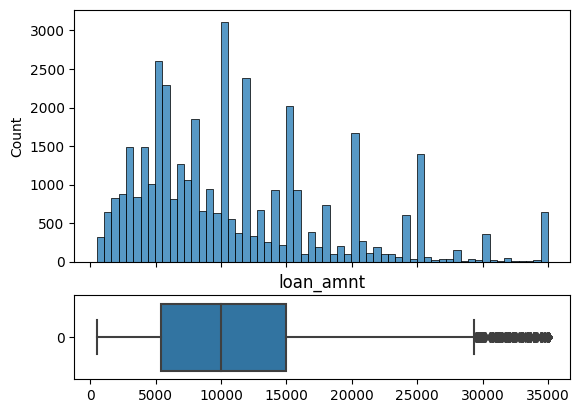

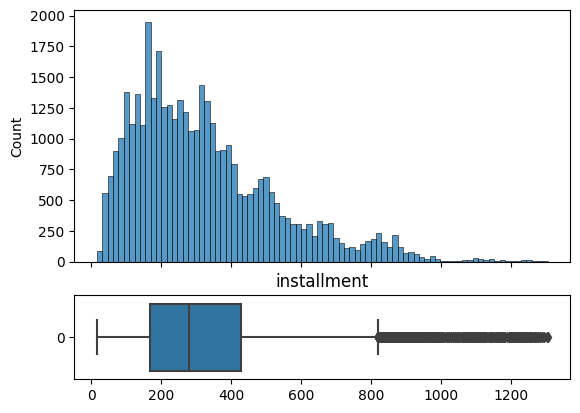

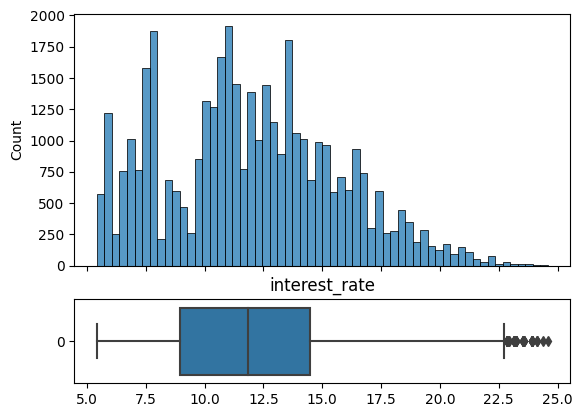

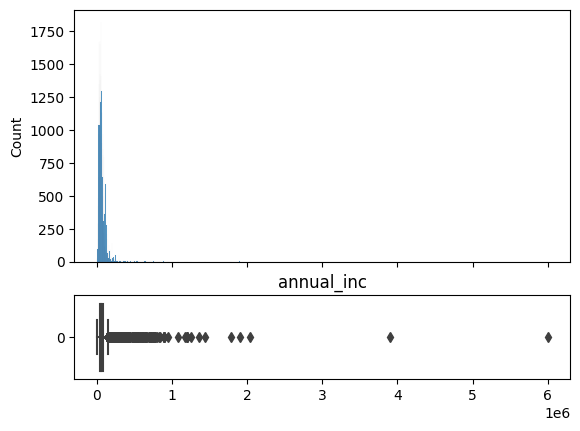

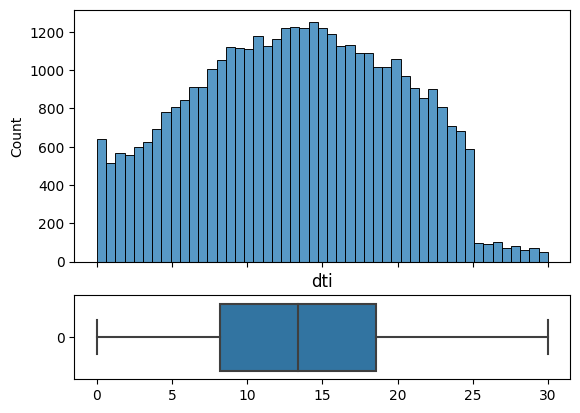

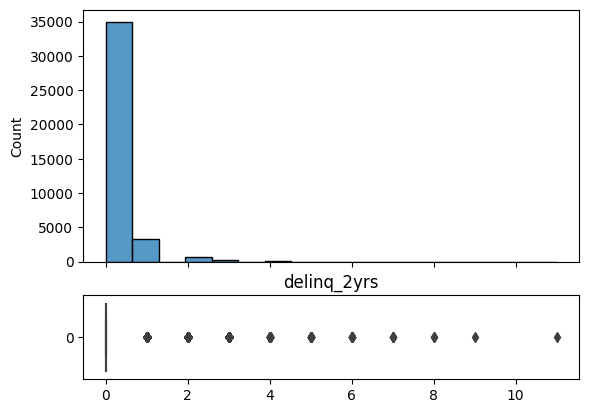

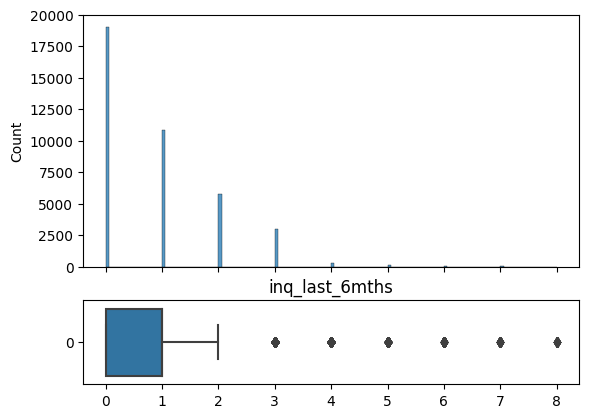

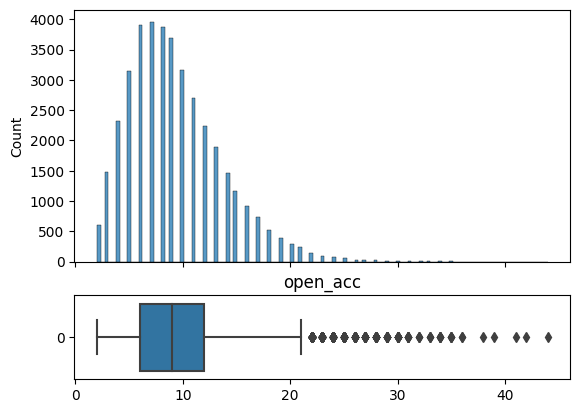

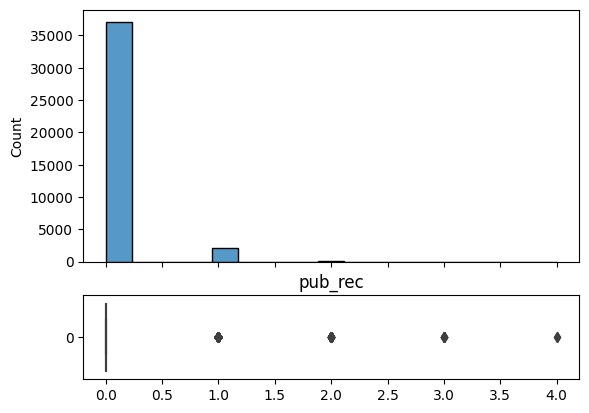

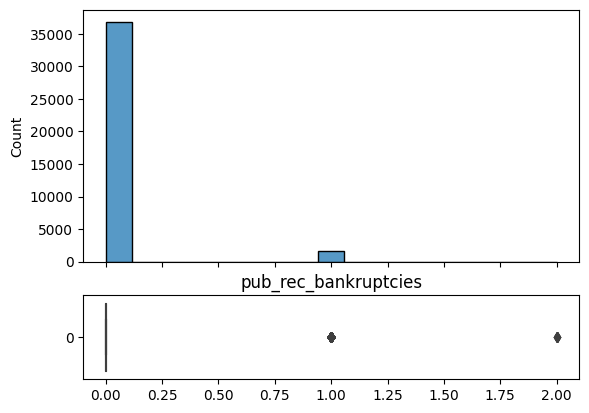

In [ ]:
#Using boxplots and histograms to check the distribution and presence of outliers.
for columns in numeric_data:
  fig, (hist, box) = plt.subplots (2, 1, sharex = True, gridspec_kw={'height_ratios': [3, 1]})
  plt.title(columns)
  sns.histplot(numeric_data[columns], ax=hist)
  sns.boxplot (data= numeric_data[columns], orient='h', ax=box)

In [ ]:
# Binning the annual income column
loan_data = loan_data.withColumn("income_class", when(loan_data["annual_inc"] < 52200,"Low")
                                 .when(((loan_data["annual_inc"] >= 52200) & (loan_data["annual_inc"] <= 156600)),"Middle")
                                 .when(loan_data["annual_inc"] > 156600, "Upper")
                                 .otherwise(""))

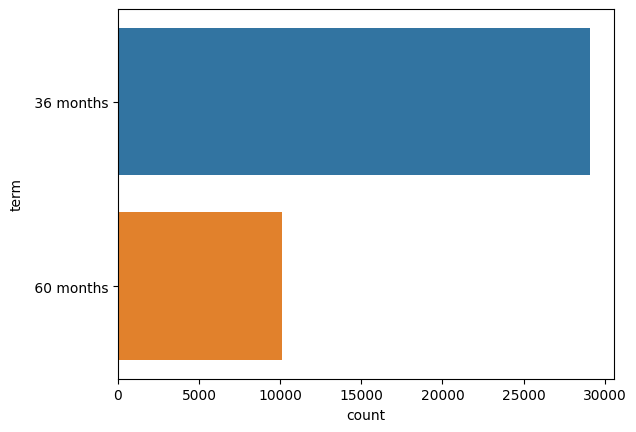

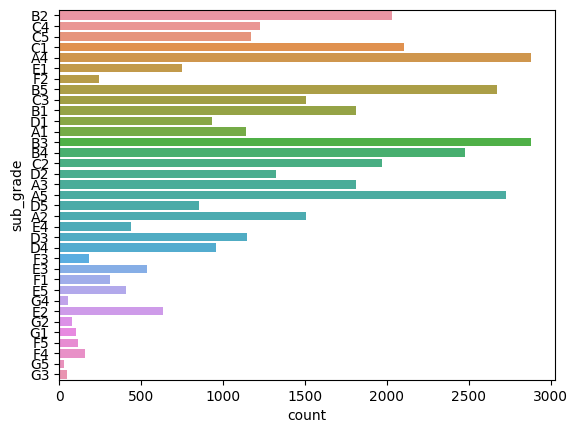

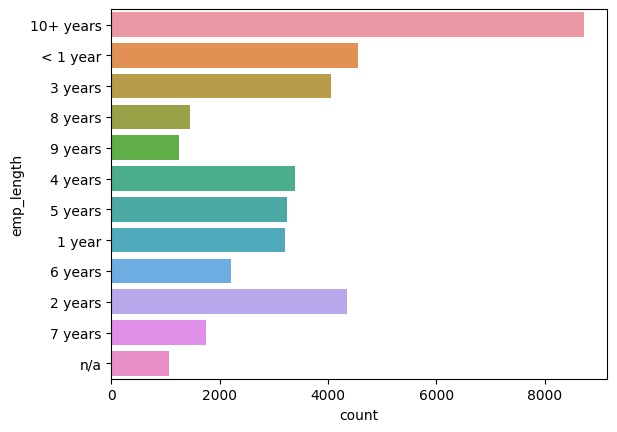

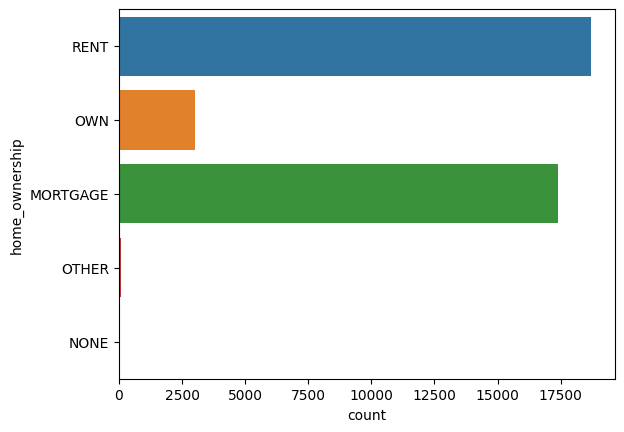

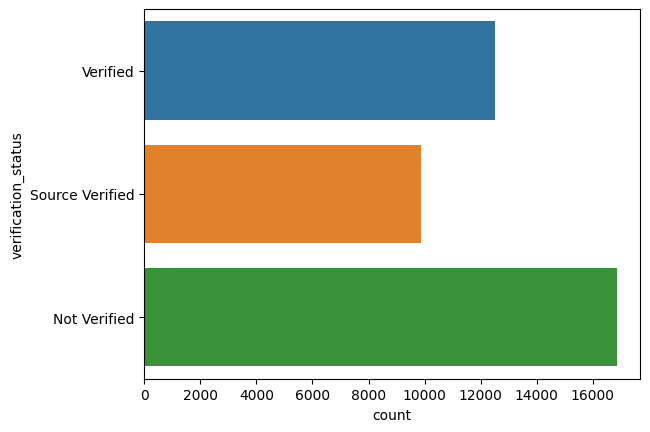

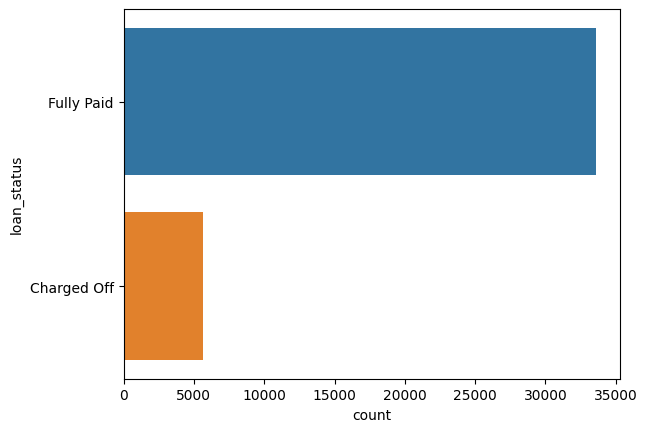

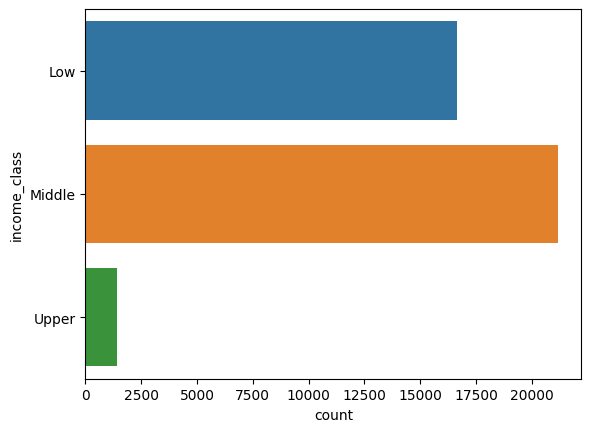

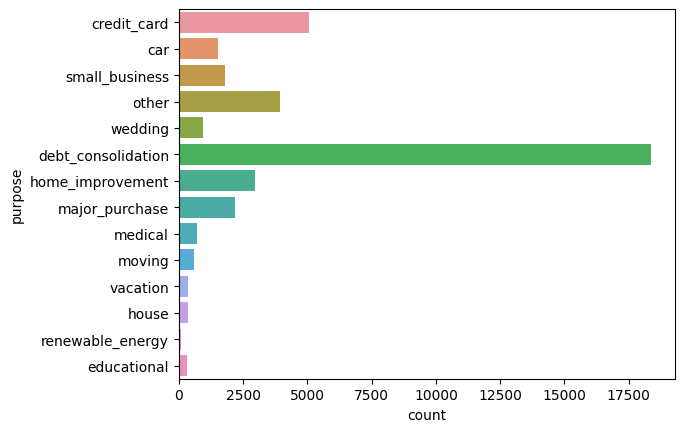

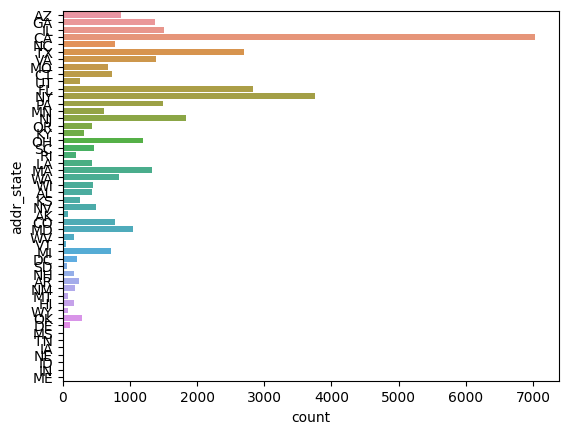

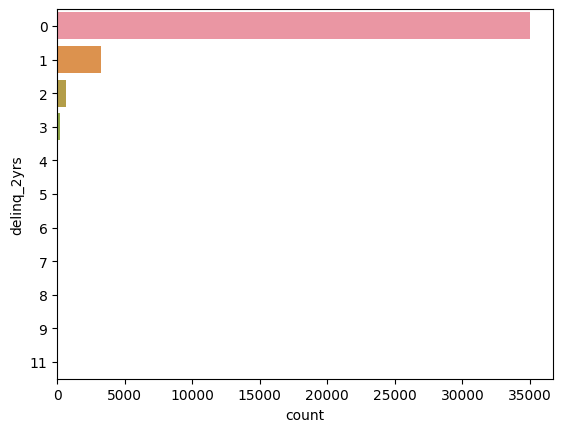

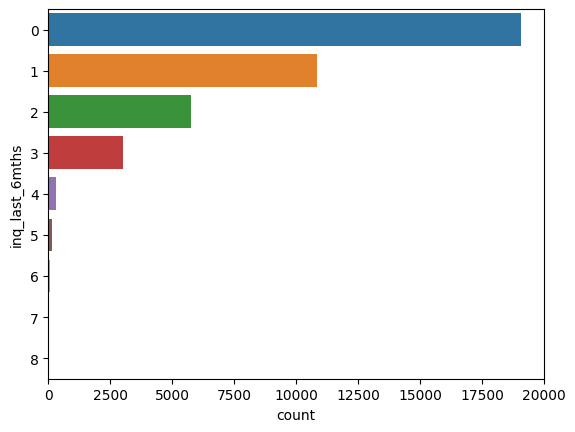

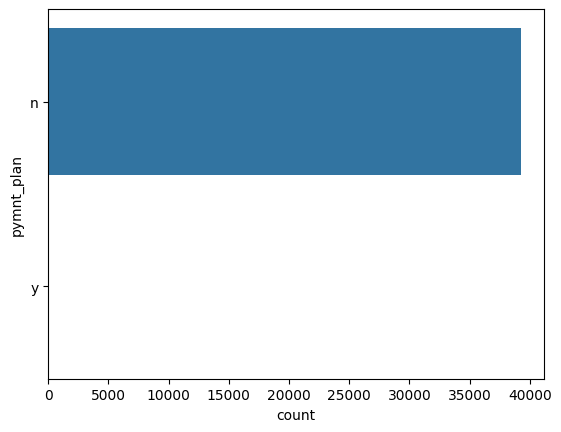

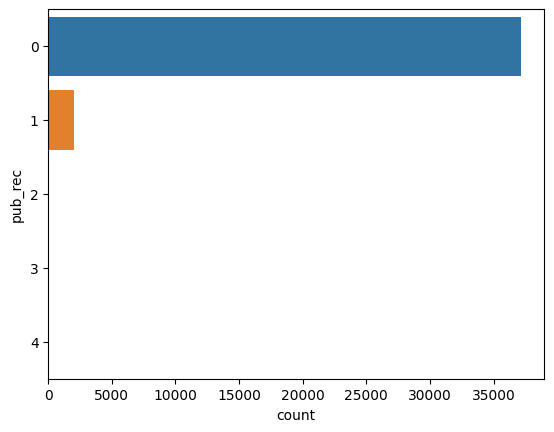

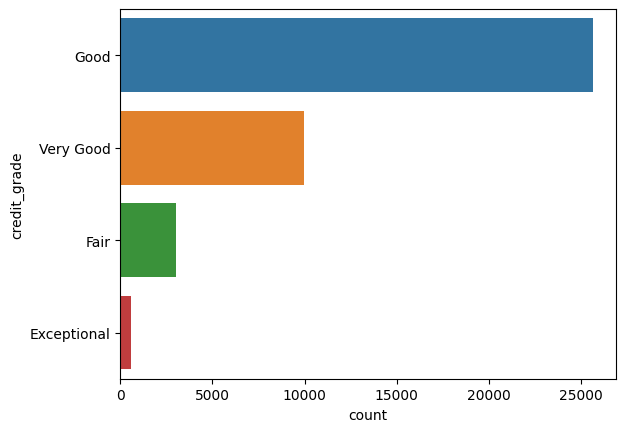

In [ ]:
# Bar charts showing frequency for each categorical column
categorical_columns = ["term", "sub_grade", "emp_length", "home_ownership", "verification_status", "loan_status", "income_class", "purpose", "addr_state", "delinq_2yrs", "inq_last_6mths", "pymnt_plan", "pub_rec", "credit_grade"]
categorical_data = loan_data.select(categorical_columns).toPandas()
for columns in categorical_data:
  sns.countplot(data = categorical_data, y = columns)
  plt.show()

In [ ]:
# Using a Loop to get a count of  the unique values in each categorical variable
for columns in categorical_data:
  print (columns, '\n', categorical_data[columns].value_counts().sort_values(ascending = False), '\n')

term 
  36 months    29096
 60 months    10143
Name: term, dtype: int64 

sub_grade 
 B3    2883
A4    2881
A5    2726
B5    2674
B4    2478
C1    2108
B2    2032
C2    1973
B1    1811
A3    1810
A2    1508
C3    1506
D2    1322
C4    1224
C5    1174
D3    1146
A1    1139
D4     957
D1     931
D5     857
E1     748
E2     637
E3     537
E4     442
E5     408
F1     314
F2     246
F3     182
F4     159
F5     115
G1     101
G2      77
G4      56
G3      47
G5      30
Name: sub_grade, dtype: int64 

emp_length 
 10+ years    8717
< 1 year     4556
2 years      4349
3 years      4054
4 years      3394
5 years      3250
1 year       3214
6 years      2202
7 years      1742
8 years      1459
9 years      1245
n/a          1057
Name: emp_length, dtype: int64 

home_ownership 
 RENT        18714
MORTGAGE    17396
OWN          3028
OTHER          98
NONE            3
Name: home_ownership, dtype: int64 

verification_status 
 Not Verified       16845
Verified           12526
Source Verified    

In [ ]:
# Dropping Payment Plan Column
loan_data = loan_data.drop("pymnt_plan")
categorical_data = categorical_data.drop("pymnt_plan", axis = 1)

Text(0.5, 1.0, 'Correlation Heatmap')

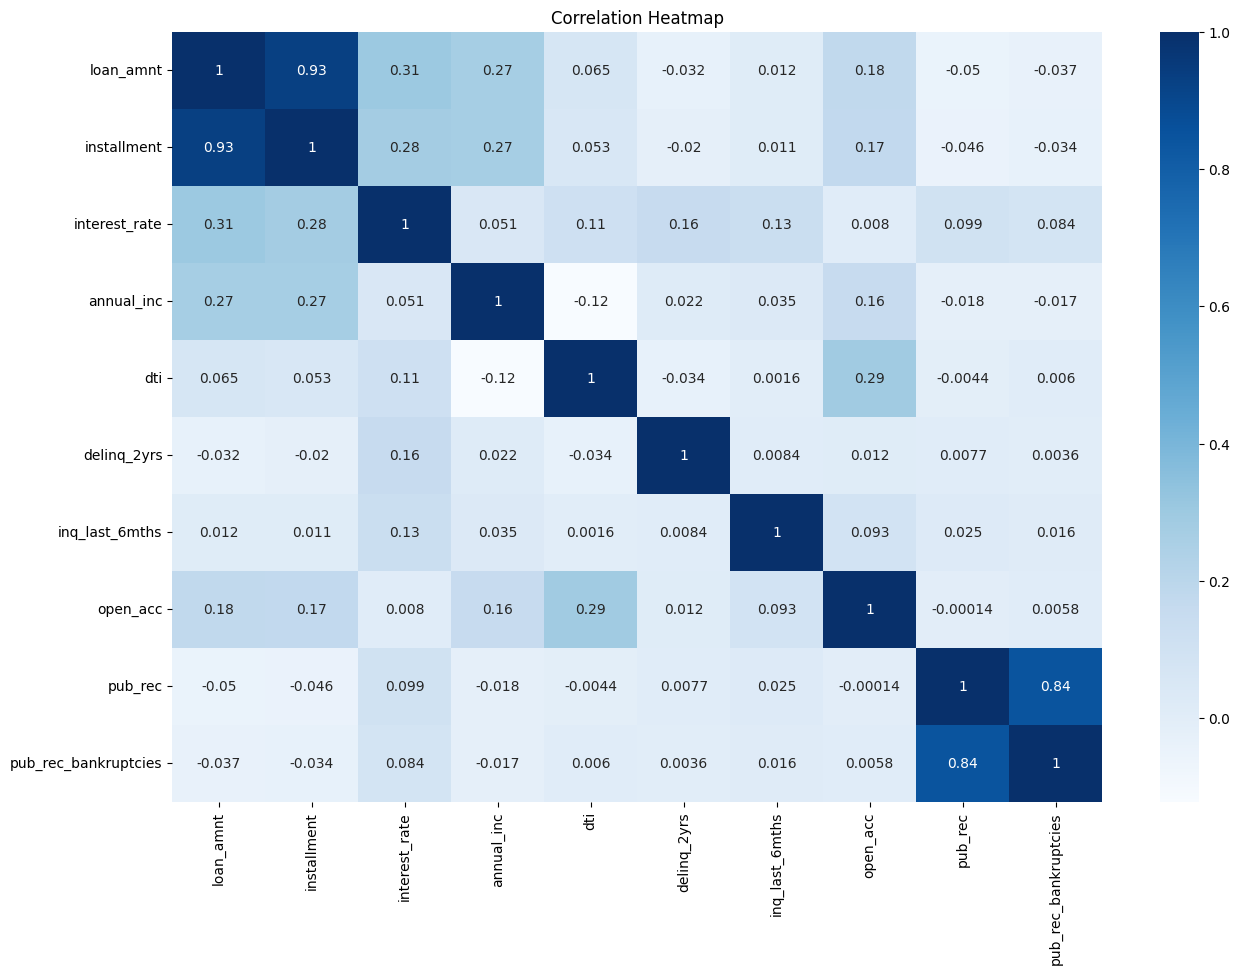

In [ ]:
# Correlation heatmap of numeric variables
fig = plt.figure(figsize = (15,10))
sns.heatmap(numeric_data.corr(method = 'pearson'), annot = True, cmap = "Blues")
plt.title("Correlation Heatmap")

In [ ]:
# Dropping pub_rec_bankruptcies and installment to avoid multicolinearity
loan_data = loan_data.drop("pub_rec_bankruptcies", "installment")
numeric_data = numeric_data.drop(columns = ["pub_rec_bankruptcies", "installment"])

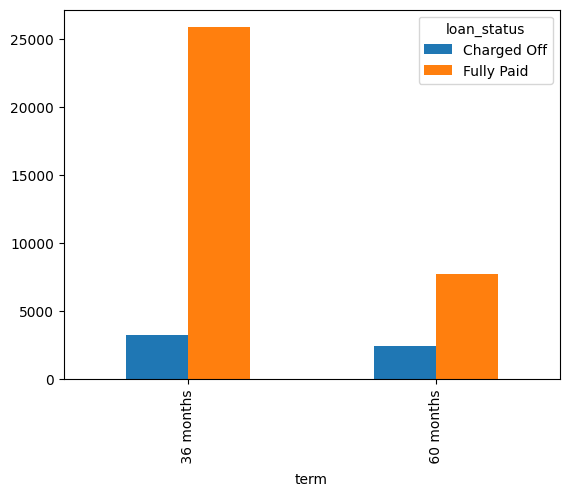

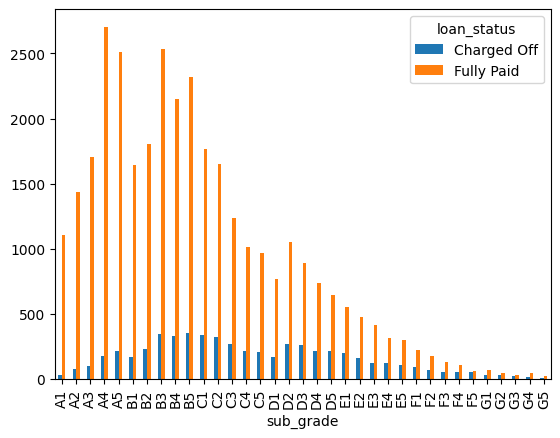

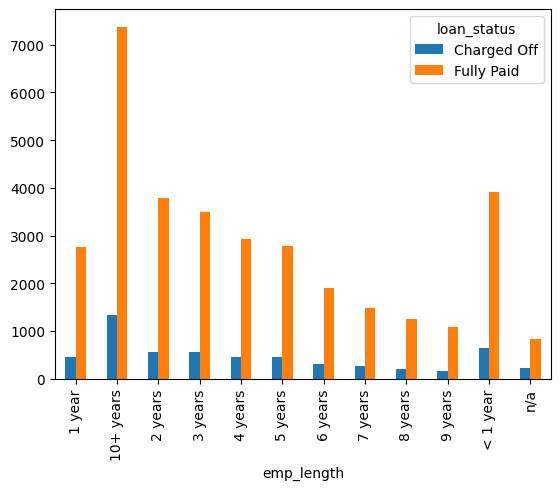

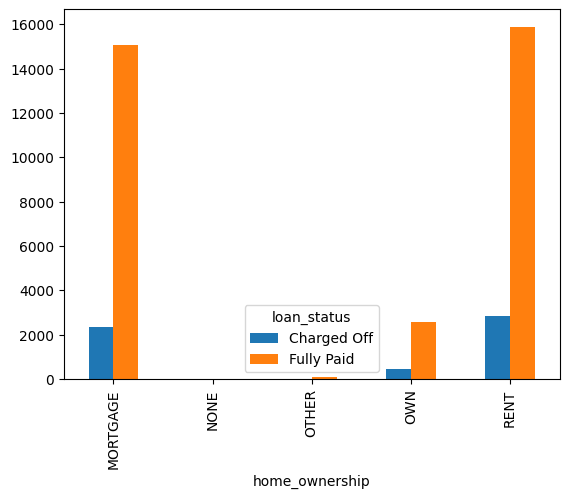

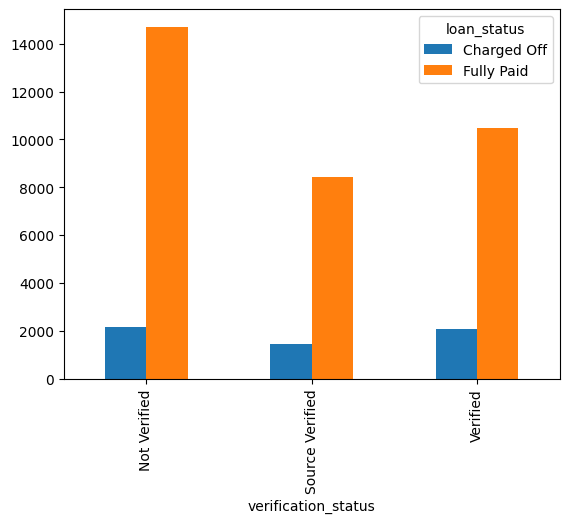

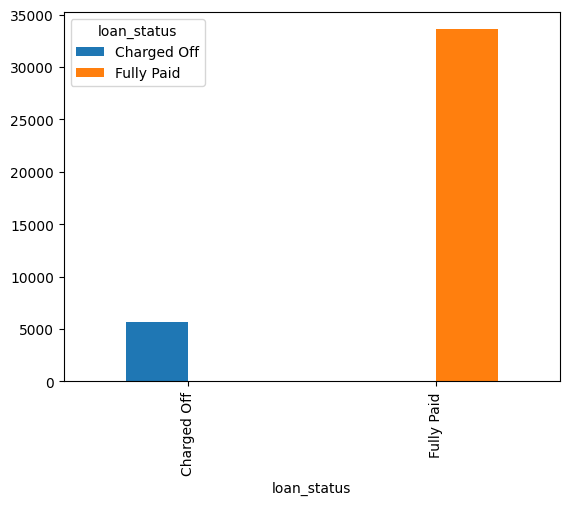

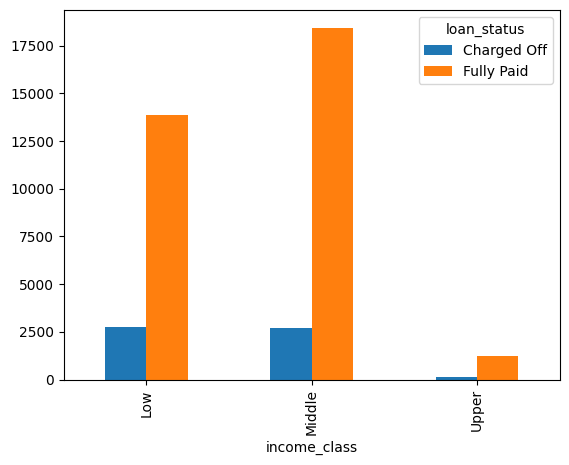

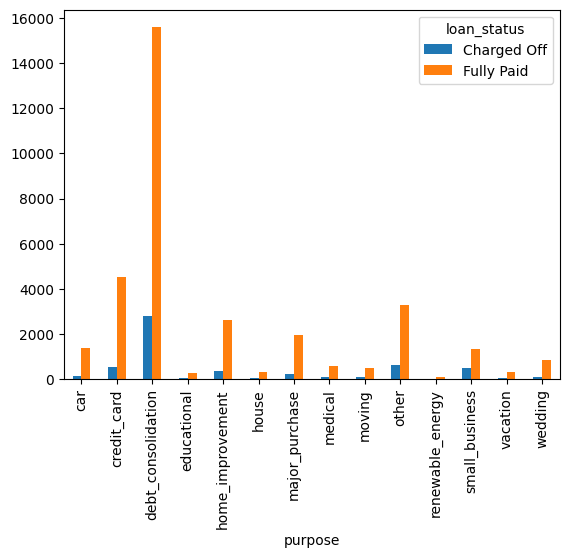

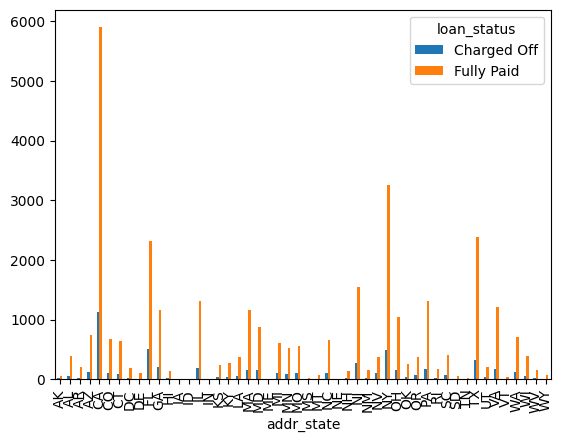

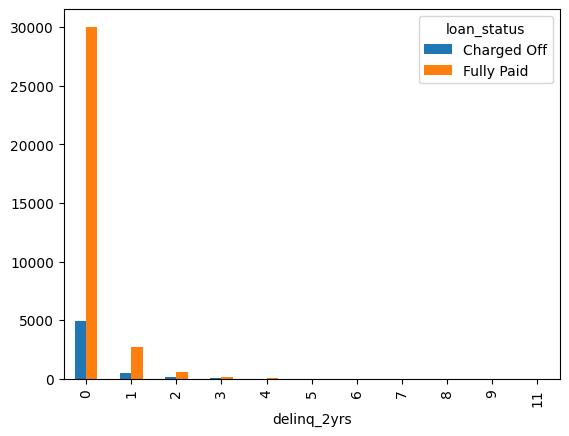

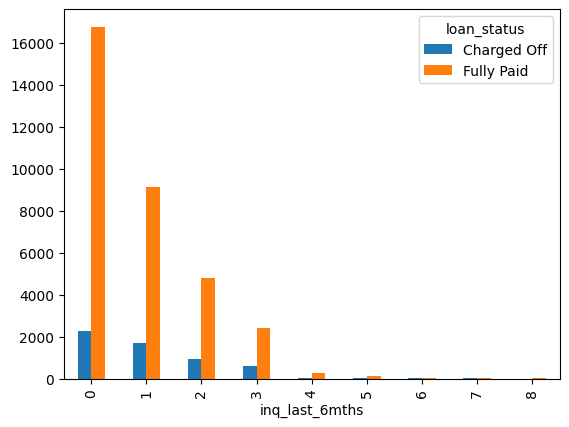

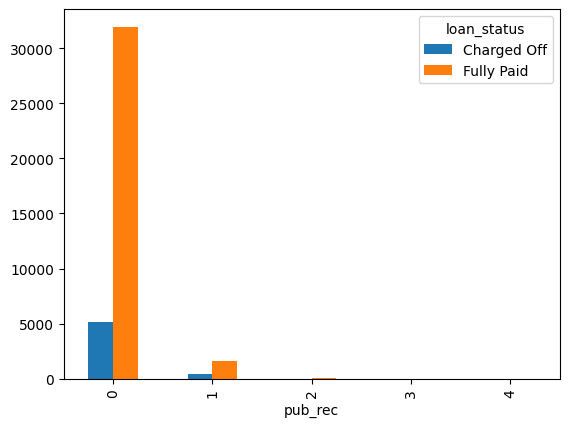

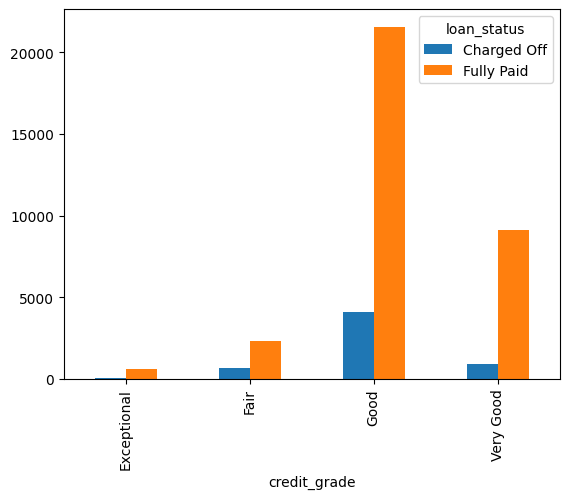

In [ ]:
# Bar charts comparing categorical variables to the target variable
import numpy as np
for columns in categorical_data.columns:
 categorical_data.groupby([columns, "loan_status"])["loan_status"].count().unstack().plot.bar()

<Axes: xlabel='verification_status', ylabel='loan_amnt'>

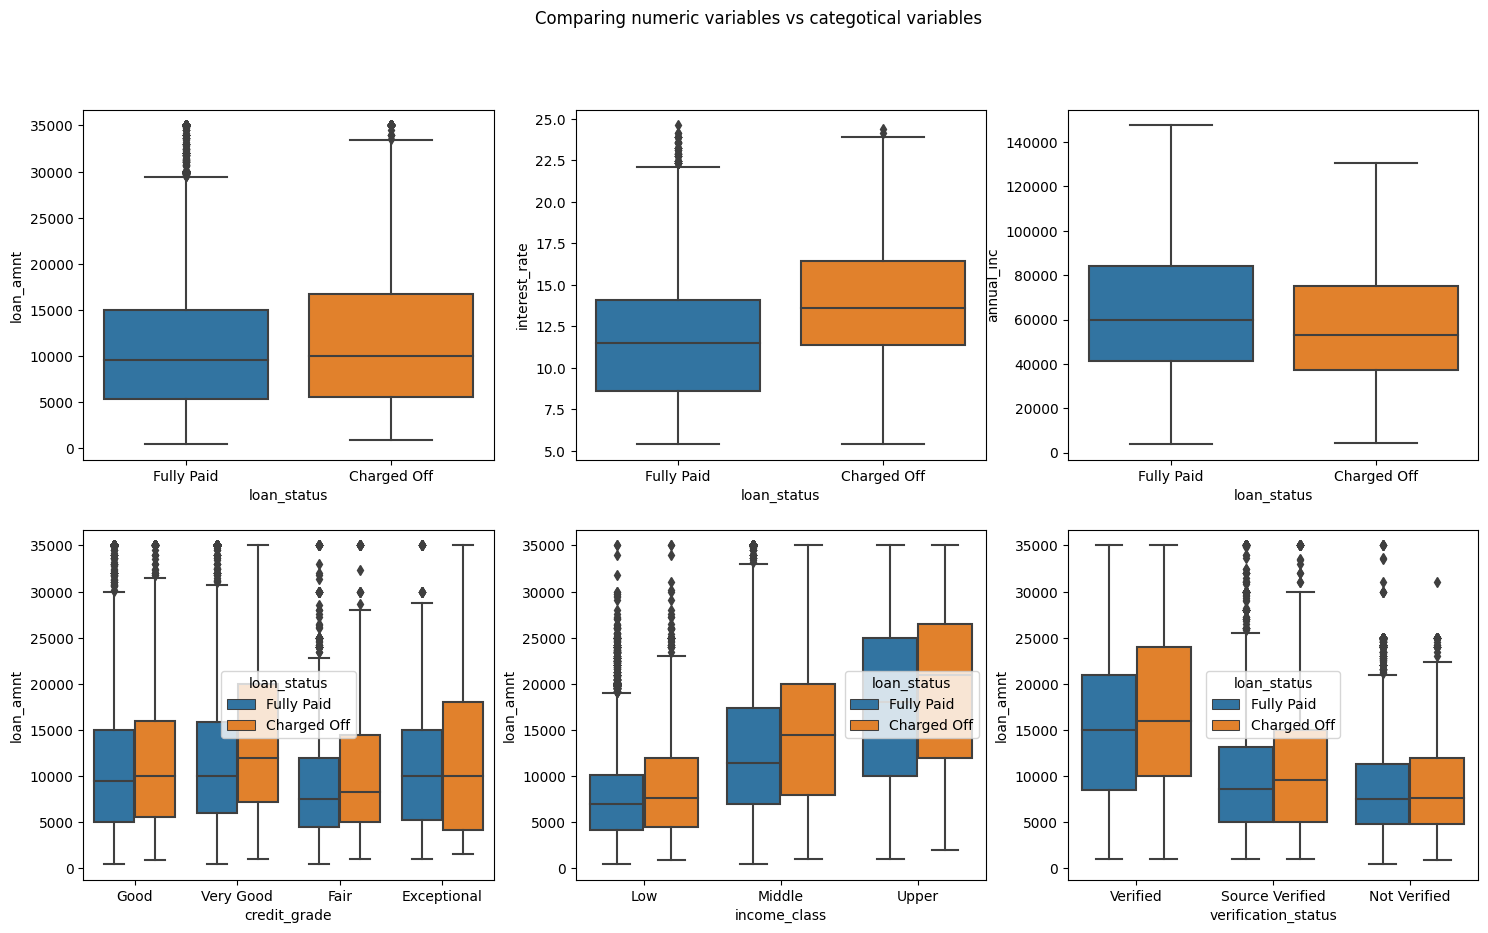

In [ ]:
# Boxplots comparing categorical and numeric variables to the target variable
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparing numeric variables vs categotical variables')
sns.boxplot(ax=axes[0, 0], data = loan_data.toPandas(), x = "loan_status",  y = "loan_amnt")
sns.boxplot(ax=axes[0, 1], data = loan_data.toPandas(), x = "loan_status",  y = "interest_rate")
sns.boxplot(ax=axes[0, 2], data = loan_data.toPandas(), x = "loan_status",  y = "annual_inc", showfliers = False) # To remove outliers
sns.boxplot(ax=axes[1, 0], data = loan_data.toPandas(), x = "credit_grade",  y = "loan_amnt", hue = "loan_status")
sns.boxplot(ax=axes[1, 1], data = loan_data.toPandas(), x = "income_class",  y = "loan_amnt", hue = "loan_status")
sns.boxplot(ax=axes[1, 2], data = loan_data.toPandas(), x = "verification_status",  y = "loan_amnt", hue = "loan_status")

In [ ]:
# Summary statistics for annual_inc and loan_amnt
from pandas.core.groupby import groupby
display(loan_data.toPandas().groupby("loan_status")["annual_inc"].describe())
display(loan_data.toPandas().groupby("loan_status")["loan_amnt"].describe())

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,5653.0,62482.635599,47728.444338,4080.0,37008.0,53000.0,75000.0,1250000.0
Fully Paid,33586.0,69961.818222,66287.700331,4000.0,41501.1,60000.0,84000.0,6000000.0


,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,5653.0,12133.849284,8099.601906,900.0,5600.0,10000.0,16750.0,35000.0
Fully Paid,33586.0,10966.564193,7260.165934,500.0,5375.0,9600.0,15000.0,35000.0


In [ ]:
# Percentage of fully_paid and charged_off for each categorical variable
for col in categorical_data:
  display(pd.crosstab(categorical_data[col], categorical_data["loan_status"], normalize='index'))

loan_status,Charged Off,Fully Paid
term,,
36 months,0.110909,0.889091
60 months,0.239180,0.760820


loan_status,Charged Off,Fully Paid
sub_grade,,
A1,0.026339,0.973661
A2,0.049072,0.950928
A3,0.056906,0.943094
A4,0.061784,0.938216
A5,0.079604,0.920396
B1,0.094423,0.905577
B2,0.112205,0.887795
B3,0.120014,0.879986
B4,0.132768,0.867232


loan_status,Charged Off,Fully Paid
emp_length,,
1 year,0.142502,0.857498
10+ years,0.153723,0.846277
2 years,0.130835,0.869165
3 years,0.137395,0.862605
4 years,0.137006,0.862994
5 years,0.141231,0.858769
6 years,0.139873,0.860127
7 years,0.150976,0.849024
8 years,0.141193,0.858807


loan_status,Charged Off,Fully Paid
home_ownership,,
MORTGAGE,0.134744,0.865256
NONE,0.000000,1.000000
OTHER,0.183673,0.816327
OWN,0.146962,0.853038
RENT,0.152079,0.847921


loan_status,Charged Off,Fully Paid
verification_status,,
Not Verified,0.127278,0.872722
Source Verified,0.146332,0.853668
Verified,0.164857,0.835143


loan_status,Charged Off,Fully Paid
loan_status,,
Charged Off,1.0,0.0
Fully Paid,0.0,1.0


loan_status,Charged Off,Fully Paid
income_class,,
Low,0.166757,0.833243
Middle,0.128484,0.871516
Upper,0.109687,0.890313


loan_status,Charged Off,Fully Paid
purpose,,
car,0.104167,0.895833
credit_card,0.107368,0.892632
debt_consolidation,0.151606,0.848394
educational,0.172308,0.827692
home_improvement,0.118345,0.881655
house,0.158602,0.841398
major_purchase,0.101648,0.898352
medical,0.153623,0.846377
moving,0.158076,0.841924


loan_status,Charged Off,Fully Paid
addr_state,,
AK,0.189873,0.810127
AL,0.122172,0.877828
AR,0.115702,0.884298
AZ,0.144175,0.855825
CA,0.160478,0.839522
CO,0.125964,0.874036
CT,0.127371,0.872629
DC,0.070423,0.929577
DE,0.105263,0.894737


loan_status,Charged Off,Fully Paid
delinq_2yrs,,
0,0.141758,0.858242
1,0.155848,0.844152
2,0.192364,0.807636
3,0.165138,0.834862
4,0.216667,0.783333
5,0.142857,0.857143
6,0.100000,0.900000
7,0.250000,0.750000
8,0.500000,0.500000


loan_status,Charged Off,Fully Paid
inq_last_6mths,,
0,0.120357,0.879643
1,0.155595,0.844405
2,0.164319,0.835681
3,0.205620,0.794380
4,0.157895,0.842105
5,0.193103,0.806897
6,0.253968,0.746032
7,0.285714,0.714286
8,0.214286,0.785714


loan_status,Charged Off,Fully Paid
pub_rec,,
0,0.139568,0.860432
1,0.225049,0.774951
2,0.204082,0.795918
3,0.000000,1.000000
4,0.000000,1.000000


loan_status,Charged Off,Fully Paid
credit_grade,,
Exceptional,0.054636,0.945364
Fair,0.226698,0.773302
Good,0.158451,0.841549
Very Good,0.087696,0.912304


In [ ]:
# Dropping state Column
loan_data = loan_data.drop("addr_state")

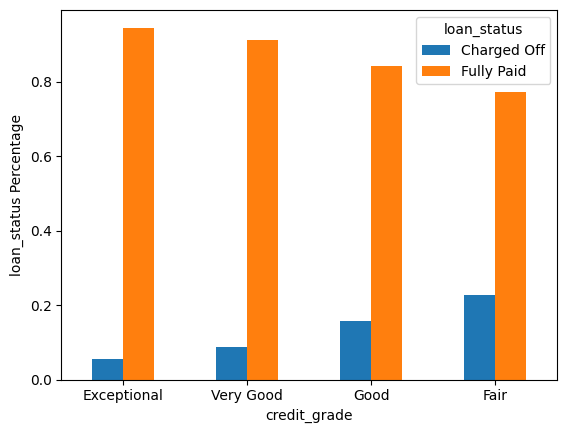

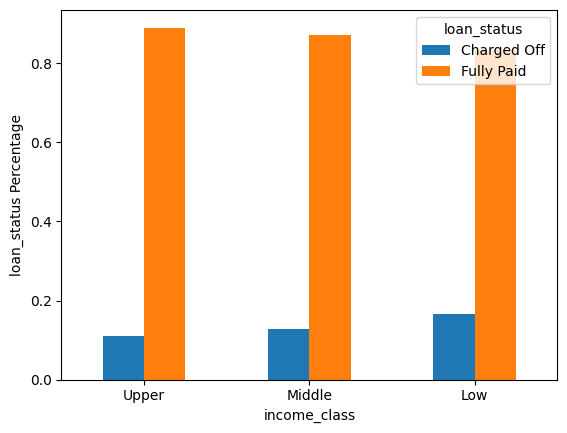

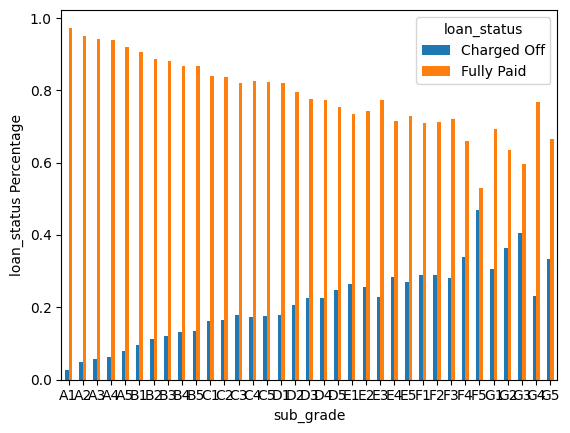

In [ ]:
# Barchart showing the percentage  of loan status against credit_grade
pd.DataFrame(pd.crosstab(categorical_data["credit_grade"], categorical_data["loan_status"], normalize='index')).sort_values(by = "Charged Off" ).plot.bar()
plt.ylabel("loan_status Percentage")
plt.xticks(rotation=0)

# Barchart showing the percentage  of loan status against income_class
pd.DataFrame(pd.crosstab(categorical_data["income_class"], categorical_data["loan_status"], normalize='index')).sort_values(by = "Charged Off" ).plot.bar()
plt.ylabel("loan_status Percentage")
plt.xticks(rotation=0)

# Barchart showing the percentage  of loan status against sub_grade
pd.DataFrame(pd.crosstab(categorical_data["sub_grade"], categorical_data["loan_status"], normalize='index')).plot.bar()
plt.ylabel("loan_status Percentage")
plt.xticks(rotation=0)
plt.rcParams["figure.figsize"] = (10,6)

# Feature Engineering

In [ ]:
# Manual Encoding of Ordinal data
loan_data_indexed = loan_data.withColumn("credit_grade_indexed", when(loan_data["credit_grade"] == "Fair", 0.0)
                                 .when(loan_data["credit_grade"] =="Good", 1.0)
                                 .when(loan_data["credit_grade"] =="Very Good",2.0)
                                 .when(loan_data["credit_grade"] == "Exceptional", 3.0)
                                 .otherwise("").cast("double"))

loan_data_indexed = loan_data_indexed.withColumn("income_class_indexed", when(loan_data["income_class"] == "Low", 0.0)
                                 .when(loan_data["income_class"] =="Middle", 1.0)
                                 .when(loan_data["income_class"] =="Upper",2.0)
                                 .otherwise("").cast("double"))

loan_data_indexed = loan_data_indexed.withColumn("emp_length_indexed", when(loan_data["emp_length"] == "n/a", 0.0)
                                 .when(loan_data["emp_length"] =="< 1 year", 1.0)
                                 .when(loan_data["emp_length"] =="1 year",2.0)
                                 .when(loan_data["emp_length"] == "2 years", 3.0)
                                 .when(loan_data["emp_length"] == "3 years", 4.0)
                                 .when(loan_data["emp_length"] == "4 years", 5.0)
                                 .when(loan_data["emp_length"] == "5 years", 6.0)
                                 .when(loan_data["emp_length"] == "6 years", 7.0)
                                 .when(loan_data["emp_length"] == "7 years", 8.0)
                                 .when(loan_data["emp_length"] == "8 years", 9.0)
                                 .when(loan_data["emp_length"] == "9 years", 10.0)
                                 .when(loan_data["emp_length"] == "10+ years", 11.0)
                                 .otherwise("").cast("double"))

# Encoding the other categorical data with string indexer
from pyspark.ml.feature import StringIndexer
# Indexing the categorical Data
indexer = StringIndexer(inputCols=["sub_grade", "term", "home_ownership", "verification_status", "purpose"], outputCols=["sub_grade_indexed", "term_indexed", "home_ownership_indexed", "verification_status_indexed", "purpose_indexed"], stringOrderType="alphabetAsc")
loan_data_indexed = indexer.fit(loan_data_indexed).transform(loan_data_indexed)

# Encoding the target variable
indexer = StringIndexer(inputCol= "loan_status", outputCol= "loan_status_label")
loan_data_indexed = indexer.fit(loan_data_indexed).transform(loan_data_indexed)


# display the encoded DataFrame
loan_data_indexed.show()



+-------+---------+----------+---------+----------+--------------+----------+-------------------+-----------+------------------+-----+-----------+--------------+--------+-------+-------------+------------+------------+--------------------+--------------------+------------------+-----------------+------------+----------------------+---------------------------+---------------+-----------------+
|     id|loan_amnt|      term|sub_grade|emp_length|home_ownership|annual_inc|verification_status|loan_status|           purpose|  dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|interest_rate|credit_grade|income_class|credit_grade_indexed|income_class_indexed|emp_length_indexed|sub_grade_indexed|term_indexed|home_ownership_indexed|verification_status_indexed|purpose_indexed|loan_status_label|
+-------+---------+----------+---------+----------+--------------+----------+-------------------+-----------+------------------+-----+-----------+--------------+--------+-------+-------------+------------+---

In [ ]:
# One hot encoding and scaling
from pyspark.ml.feature import OneHotEncoder, StandardScaler, VectorAssembler
from pyspark.ml import Pipeline

# Encoding the categorical data using OneHotEncoder
encoder = OneHotEncoder(inputCols=["home_ownership_indexed","verification_status_indexed", "purpose_indexed"], outputCols=["home_ownership_ohe", "verification_status_ohe", "purpose_ohe"], dropLast=False)
loan_data_ohe = encoder.fit(loan_data_indexed).transform(loan_data_indexed)

# Scaling the numerical data using standardScaler
numeric_cols = ["loan_amnt", "interest_rate", "annual_inc", "dti", "delinq_2yrs", "inq_last_6mths", "open_acc", "pub_rec"]
assembler = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in numeric_cols]
scaler = [StandardScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in numeric_cols]
pipeline = Pipeline(stages=assembler + scaler)
scalerModel = pipeline.fit(loan_data_ohe)
scaled_encoded_data = scalerModel.transform(loan_data_ohe)
scaled_encoded_data.show()

+-------+---------+----------+---------+----------+--------------+----------+-------------------+-----------+------------------+-----+-----------+--------------+--------+-------+-------------+------------+------------+--------------------+--------------------+------------------+-----------------+------------+----------------------+---------------------------+---------------+-----------------+------------------+-----------------------+---------------+-------------+-----------------+--------------+-------+---------------+------------------+------------+-----------+--------------------+--------------------+--------------------+--------------------+-------------------+---------------------+--------------------+--------------+
|     id|loan_amnt|      term|sub_grade|emp_length|home_ownership|annual_inc|verification_status|loan_status|           purpose|  dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|interest_rate|credit_grade|income_class|credit_grade_indexed|income_class_indexed|emp_leng

In [ ]:
# Assembling the data into features and column
Indexed_cat_cols = ["credit_grade_indexed", "income_class_indexed", "emp_length_indexed", "sub_grade_indexed", "term_indexed"]
Encoded_cat_cols = ["home_ownership_ohe", "verification_status_ohe", "purpose_ohe"]
Scaled_numeric_cols = ["loan_amnt_scaled", "interest_rate_scaled", "annual_inc_scaled", "dti_scaled", "delinq_2yrs_scaled", "inq_last_6mths_scaled", "open_acc_scaled", "pub_rec_scaled"]
label = ["loan_status_label"]
assemblerInputs = Indexed_cat_cols + Encoded_cat_cols + Scaled_numeric_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol = "features")
Assembled_data = assembler.transform(scaled_encoded_data)

In [ ]:
# Selecting important columns
loan_data_final = Assembled_data.select('features', 'loan_status_label', 'id', 'loan_amnt', 'term', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'loan_status', 'purpose',
                                        'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'credit_grade', 'interest_rate', 'income_class')
loan_data_final.show()

+--------------------+-----------------+-------+---------+----------+---------+----------+--------------+----------+-------------------+-----------+------------------+-----+-----------+--------------+--------+-------+------------+-------------+------------+
|            features|loan_status_label|     id|loan_amnt|      term|sub_grade|emp_length|home_ownership|annual_inc|verification_status|loan_status|           purpose|  dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|credit_grade|interest_rate|income_class|
+--------------------+-----------------+-------+---------+----------+---------+----------+--------------+----------+-------------------+-----------+------------------+-----+-----------+--------------+--------+-------+------------+-------------+------------+
|(35,[0,2,3,9,12,1...|              0.0|1077501|     5000| 36 months|       B2| 10+ years|          RENT|   24000.0|           Verified| Fully Paid|       credit_card|27.65|          0|             1|       3|      0|        G

#Unsupervised Learning

Text(0, 0.5, 'Silhouette Score')

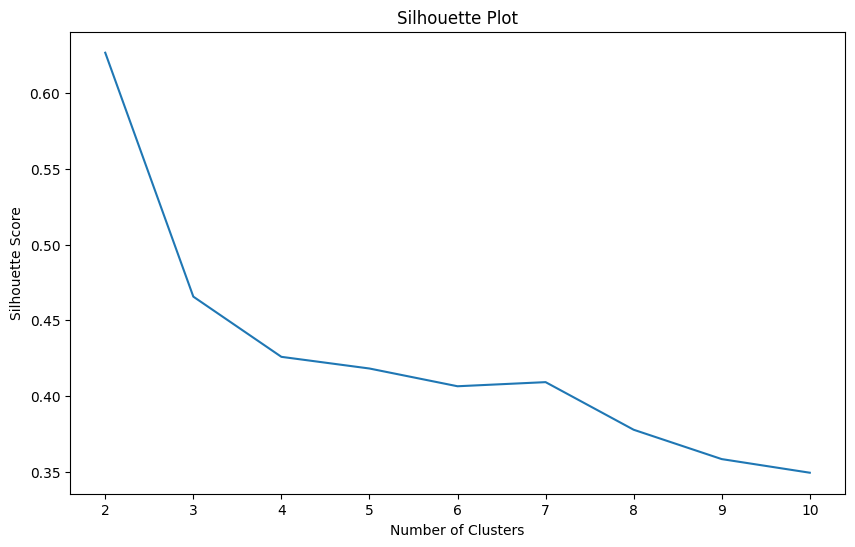

In [ ]:
#KMeans Clustering
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Iterating over different values of k to find the optimal number of clusters
silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')

for K in range(2,11):
    KMeans_=KMeans(featuresCol='features', k=K, seed = 55)
    KMeans_fit=KMeans_.fit(loan_data_final)
    KMeans_transform=KMeans_fit.transform(loan_data_final)
    evaluation_score=evaluator.evaluate(KMeans_transform)
    silhouette_scores.append(evaluation_score)

#plotting the silhouette score for each number of clusters.
plt.title("Silhouette Plot")
plt.plot(range(2,11),silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

In [ ]:
# Building the kmeans model with 2 clusters.
KMeans_=KMeans(featuresCol='features', k=2, seed = 55)
KMeans_Model=KMeans_.fit(loan_data_final)
cluster_df = KMeans_Assignments=KMeans_Model.transform(loan_data_final)
cluster_df.show()

+--------------------+-----------------+-------+---------+----------+---------+----------+--------------+----------+-------------------+-----------+------------------+-----+-----------+--------------+--------+-------+------------+-------------+------------+----------+
|            features|loan_status_label|     id|loan_amnt|      term|sub_grade|emp_length|home_ownership|annual_inc|verification_status|loan_status|           purpose|  dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|credit_grade|interest_rate|income_class|prediction|
+--------------------+-----------------+-------+---------+----------+---------+----------+--------------+----------+-------------------+-----------+------------------+-----+-----------+--------------+--------+-------+------------+-------------+------------+----------+
|(35,[0,2,3,9,12,1...|              0.0|1077501|     5000| 36 months|       B2| 10+ years|          RENT|   24000.0|           Verified| Fully Paid|       credit_card|27.65|          0|        

<Axes: title={'center': 'Scatterplot of clusters'}, xlabel='PC1', ylabel='PC2'>

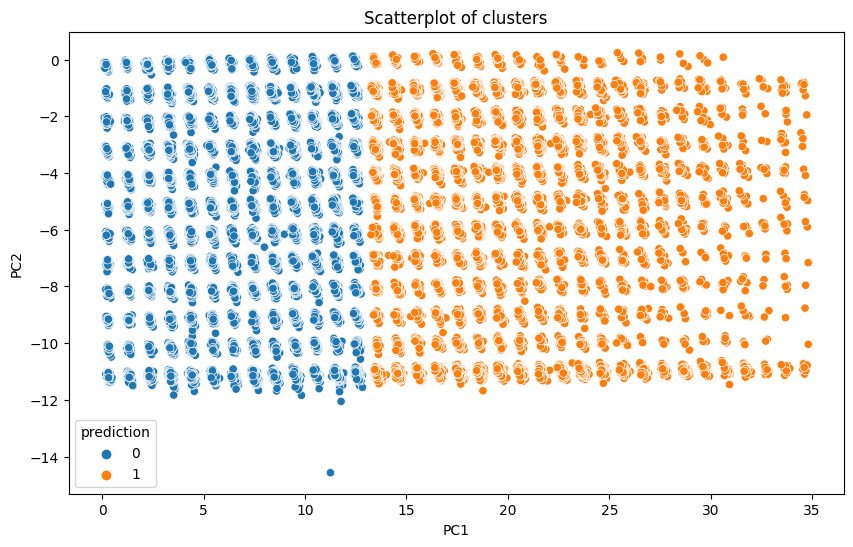

In [ ]:
# Visualizing the clusters with Principal Component Analysis
from pyspark.ml.feature import PCA
# Create a PCA instance and fit to data
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
model = pca.fit(cluster_df)
# Transform data using the PCA model
transformed_data = model.transform(cluster_df)

# Extracting the principal components and prediction
kCluster = transformed_data.select("pca_features", "prediction")
kCluster = transformed_data.rdd.map(lambda x: [float(y) for y in x['pca_features'][0:2]] + [x['prediction']]).toDF(["PC1", "PC2", "prediction"])

# Visualizing the clusters
plt.title("Scatterplot of clusters")
sns.scatterplot(data=kCluster.toPandas(), x="PC1", y="PC2", hue="prediction")


In [ ]:
# Comparing the clusters to the target variable
pd.crosstab(cluster_df.toPandas()["prediction"], cluster_df.toPandas()["loan_status"], normalize='index')

loan_status,Charged Off,Fully Paid
prediction,,
0,0.107668,0.892332
1,0.229633,0.770367


#Test/Train Split

In [ ]:
# Spliting into training and test sets
train, test = loan_data_final.randomSplit([0.7, 0.3], seed = 2023)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 27397
Test Dataset Count: 11842


In [ ]:
# Checking the distribution of the target variable in the training and test datatotal_count = df.count()
display(train.toPandas()["loan_status"].value_counts(normalize = True))
display(test.toPandas()["loan_status"].value_counts(normalize = True))

Fully Paid     0.855167
Charged Off    0.144833
Name: loan_status, dtype: float64

Fully Paid     0.85771
Charged Off    0.14229
Name: loan_status, dtype: float64

# Supervised Learning (Decision Trees)

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Create a Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol="features", labelCol="loan_status_label", maxBins=35, seed =55, maxDepth=6)

# Train the model
dt_model = dt.fit(train)

# Make predictions on the test data
predictions = dt_model.transform(test)
prediction_df = predictions.select('loan_status_label', 'rawPrediction', 'prediction', 'probability').toPandas()
prediction_df.head()

,loan_status_label,rawPrediction,prediction,probability
0,0.0,"[1391.0, 532.0]",0.0,"[0.7233489339573583, 0.2766510660426417]"
1,0.0,"[1644.0, 143.0]",0.0,"[0.9199776161163962, 0.0800223838836038]"
2,0.0,"[221.0, 35.0]",0.0,"[0.86328125, 0.13671875]"
3,0.0,"[1465.0, 274.0]",0.0,"[0.8424381828637147, 0.15756181713628523]"
4,0.0,"[1644.0, 143.0]",0.0,"[0.9199776161163962, 0.0800223838836038]"


In [ ]:
# Evaluate the model's performance
evaluator = BinaryClassificationEvaluator(labelCol="loan_status_label")
auc = evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderROC'})
print(f"Area under ROC = {auc}")

# Calculate other performance metrics
tp = predictions.filter("loan_status_label = 1 AND prediction = 1").count()
tn = predictions.filter("loan_status_label = 0 AND prediction = 0").count()
fp = predictions.filter("loan_status_label = 0 AND prediction = 1").count()
fn = predictions.filter("loan_status_label = 1 AND prediction = 0").count()

a = ((tp + tn)/predictions.count())
r = tp / (tp + fn)
p = tp / (tp + fp)
f1 = 2 * ((p * r)/(p + r))

print("Accuracy:", a)
print("Recall:", r)
print("Precision: ", p)
print("F1 score:", f1)

Area under ROC = 0.5461745550349133
Accuracy: 0.8565276135787874
Recall: 0.011869436201780416
Precision:  0.37037037037037035
F1 score: 0.023001725129384705


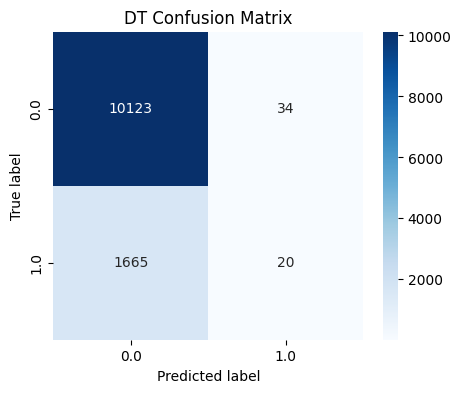

In [ ]:
# Plot confusion matrix
cm = pd.crosstab(prediction_df["loan_status_label"], prediction_df["prediction"])

fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
plt.title("DT Confusion Matrix")
plt.show()

In [ ]:
# Undersampling the majority class of the target variable to fix class imbalance
from pyspark.sql.functions import rand

# Split the dataset into majority and minority classes
majority_class = train[train["loan_status"].isin(["Fully Paid"])]
minority_class = train[train["loan_status"].isin(["Charged Off"])]

# Calculate the fraction to downsample the majority class to
fraction = minority_class.count() / majority_class.count()

# Undersample the majority class using the calculated fraction
undersampled_majority_class = majority_class.sample(False, fraction, seed=55)

# Combine the Undersampled majority class with the minority class
undersampled_df = undersampled_majority_class.union(minority_class)

# Shuffle the data to randomize the order of the samples
undersampled_df = undersampled_df.orderBy(rand())

# Count values of the target variable in the undersampled data
display(undersampled_df.toPandas()["loan_status"].value_counts())

Fully Paid     4013
Charged Off    3968
Name: loan_status, dtype: int64

In [ ]:
# Train the new model
dt_model_2 = dt.fit(undersampled_df)

# Make predictions on the test data
predictions = dt_model_2.transform(test)
prediction_df = predictions.select('loan_status_label', 'rawPrediction', 'prediction', 'probability').toPandas()
prediction_df.head()

,loan_status_label,rawPrediction,prediction,probability
0,0.0,"[339.0, 827.0]",1.0,"[0.29073756432247, 0.70926243567753]"
1,0.0,"[70.0, 63.0]",0.0,"[0.5263157894736842, 0.47368421052631576]"
2,0.0,"[98.0, 76.0]",0.0,"[0.5632183908045977, 0.4367816091954023]"
3,0.0,"[98.0, 76.0]",0.0,"[0.5632183908045977, 0.4367816091954023]"
4,0.0,"[70.0, 63.0]",0.0,"[0.5263157894736842, 0.47368421052631576]"


In [ ]:
# Evaluate the model's performance
evaluator = BinaryClassificationEvaluator(labelCol="loan_status_label")
auc = evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderROC'})
print(f"Area under ROC = {auc}")

# Calculate other performance metrics
tp = predictions.filter("loan_status_label = 1 AND prediction = 1").count()
tn = predictions.filter("loan_status_label = 0 AND prediction = 0").count()
fp = predictions.filter("loan_status_label = 0 AND prediction = 1").count()
fn = predictions.filter("loan_status_label = 1 AND prediction = 0").count()

a = ((tp + tn)/predictions.count())
r = tp / (tp + fn)
p = tp / (tp + fp)
f1 = 2 * ((p * r)/(p + r))

print("Accuracy:", a)
print("Recall:", r)
print("Precision: ", p)
print("F1 score:", f1)

Area under ROC = 0.597403319807801
Accuracy: 0.604965377470022
Recall: 0.6183976261127596
Precision:  0.20523931455584007
F1 score: 0.3081928423543331


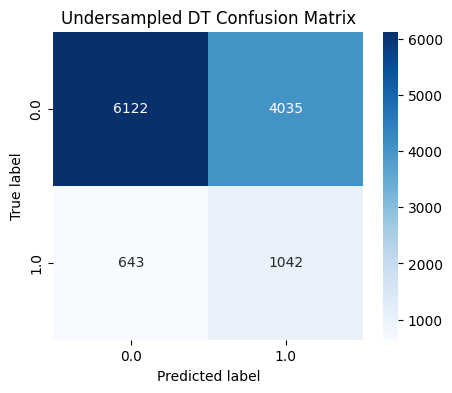

In [ ]:
# Plot confusion matrix
confusion_matrix = pd.crosstab(prediction_df["loan_status_label"], prediction_df["prediction"])

fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
plt.title("Undersampled DT Confusion Matrix")
plt.show()

In [ ]:
# Oversampling the minority class of the target variable to fix class imbalance
from pyspark.sql.functions import explode, array, lit

majority_df = train[train["loan_status"].isin(["Fully Paid"])]
minority_df = train[train["loan_status"].isin(["Charged Off"])]

ratio = int(majority_df.count()/minority_df.count())
a = range(ratio)

# duplicate the minority rows
oversampled_df = minority_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows
oversampled_df = majority_df.unionAll(oversampled_df)

# Count values of the target variable in the oversampled data
display(oversampled_df.toPandas()["loan_status"].value_counts())

Fully Paid     23429
Charged Off    19840
Name: loan_status, dtype: int64

In [ ]:
# Train the new model
dt_model_3 = dt.fit(oversampled_df)

# Make predictions on the test data
predictions = dt_model_3.transform(test)
prediction_df = predictions.select('loan_status_label', 'rawPrediction', 'prediction', 'probability').toPandas()
prediction_df.head()

,loan_status_label,rawPrediction,prediction,probability
0,0.0,"[2132.0, 4005.0]",1.0,"[0.3474010102656021, 0.6525989897343979]"
1,0.0,"[3870.0, 1685.0]",0.0,"[0.6966696669666966, 0.3033303330333033]"
2,0.0,"[198.0, 85.0]",0.0,"[0.6996466431095406, 0.3003533568904594]"
3,0.0,"[198.0, 85.0]",0.0,"[0.6996466431095406, 0.3003533568904594]"
4,0.0,"[3870.0, 1685.0]",0.0,"[0.6966696669666966, 0.3033303330333033]"


In [ ]:
# Evaluate the model's performance
evaluator = BinaryClassificationEvaluator(labelCol="loan_status_label")
auc = evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderROC'})
print(f"Area under ROC = {auc}")

# Calculate other performance metrics
tp = predictions.filter("loan_status_label = 1 AND prediction = 1").count()
tn = predictions.filter("loan_status_label = 0 AND prediction = 0").count()
fp = predictions.filter("loan_status_label = 0 AND prediction = 1").count()
fn = predictions.filter("loan_status_label = 1 AND prediction = 0").count()

a = ((tp + tn)/predictions.count())
r = tp / (tp + fn)
p = tp / (tp + fp)
f1 = 2 * ((p * r)/(p + r))

print("Accuracy:", a)
print("Recall:", r)
print("Precision: ", p)
print("F1 score:", f1)

Area under ROC = 0.5919048972672074
Accuracy: 0.6881438946123966
Recall: 0.5074183976261127
Precision:  0.22996234534696072
F1 score: 0.3164908384230983


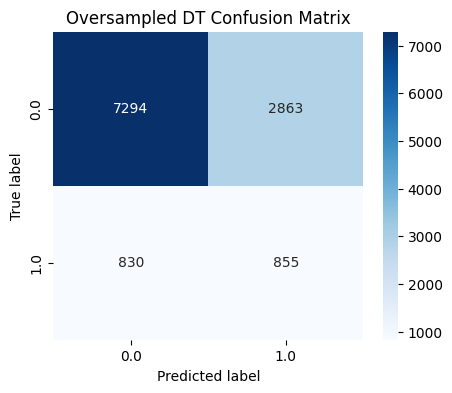

In [ ]:
# Plot confusion matrix
cm = pd.crosstab(prediction_df["loan_status_label"], prediction_df["prediction"])

fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
plt.title("Oversampled DT Confusion Matrix")
plt.show()